In [3]:
from tsdata.raw import available_data, load_data

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
plt.rcParams["figure.figsize"] = (18, 8)
pd.set_option('display.max_columns', 500)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st

from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings('ignore')

In [4]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def plotSeries(data, legend='', title=''):
    plt.figure(figsize=(20, 7))
    plt.plot(data, '-d', color='navy', markersize=3)
    plt.legend([legend], loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title(title)


def plotDecomposition(decomposition):
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    resid = decomposition.resid.dropna()

    plt.subplots(3, 1, figsize=(20, 21))

    plt.subplot(3, 1, 1)
    plt.plot(trend, color='navy', markersize=3, label='trend')
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title("Trend")

    plt.subplot(3, 1, 2)
    plt.plot(seasonal,
             '-gd', markersize=3, label='seasonal')
    plt.plot([seasonal.index[0], seasonal.index[-1]],
             seasonal.mean()*np.array([1, 1]), '--k',
             label=f"mean = {seasonal.mean():.3g}")
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title(
        f"Seasonal : range={(seasonal.max() - seasonal.min()):.3g}")

    plt.subplot(3, 1, 3)
    plt.plot(decomposition.resid, '-o', color='maroon',
             markersize=3,  label='residuals')
    plt.plot([resid.index[0], resid.index[-1]],
             resid.mean()*np.array([1, 1]), '--k',
             label=f"mean = {resid.mean():.3g}")
    plt.legend(loc='upper right')
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    plt.show()


def plotACF(data, decomposition, lags=50):
    trend = decomposition.trend.dronpna()
    seasonal = decomposition.seasonal.dronpna()
    resid = decomposition.resid.dropna()

    fig, axes = plt.subplots(4, 1, figsize=(15, 4*6))

    plot_acf(
        data,
        lags=lags,
        vlines_kwargs={'color': 'b'},
        markerfacecolor='b',
        markeredgecolor='b',
        title='Autocorrelation of target'
    )
    plot_acf(
        trend,
        lags=lags,
        vlines_kwargs={'color': 'navy'},
        markerfacecolor='navy',
        markeredgecolor='navy',
        title='Autocorrelation of trend'
    )
    plot_acf(
        seasonal,
        lags=lags,
        vlines_kwargs={'color': 'g'},
        markerfacecolor='g',
        markeredgecolor='g',
        title='Autocorrelation of seasonal'
    )

    plot_acf(
        resid,
        lags=lags,
        vlines_kwargs={'color': 'maroon'},
        markerfacecolor='maroon',
        markeredgecolor='maroon',
        title='Autocorrelation of residuals'
    )

    plt.show()


def plotPACF(data, decomposition, lags=36):
    trend = decomposition.trend.dronpna()
    seasonal = decomposition.seasonal.dronpna()
    resid = decomposition.resid.dropna()

    plot_acf(
        dataStat,
        lags=lags,
        vlines_kwargs={'color': 'b'},
        markerfacecolor='b', markeredgecolor='b',
        title='Autocorrelation of target'
    )

    plot_pacf(
        trend.dropna(),
        lags=lags,
        vlines_kwargs={'color': 'navy'},
        markerfacecolor='navy',
        markeredgecolor='navy',
        title='Partial autocorrelation of trend'
    )

    try:
        plot_pacf(
            seasonal,
            lags=lags,
            vlines_kwargs={'color': 'g'},
            markerfacecolor='g',
            markeredgecolor='g',
            title='Partial autocorrelation of seasonal'
        )
    except Exception as exc:
        print(exc)

    try:
        plot_pacf(
            resid,
            lags=lags,
            vlines_kwargs={'color': 'maroon'},
            markerfacecolor='maroon',
            markeredgecolor='maroon',
            title='Partial autocorrelation of residuals'
        )
    except Exception as exc:
        print(exc)

    plt.show()


def getResidAnalytics(resid):
    resid = resid.dropna()
    color = 'maroon'

    plt.subplots(1, 2, figsize=(24, 8))

    plt.subplot(1, 2, 1)
    plt.plot(resid, '-', color=color)
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    x_fit = np.linspace(resid.min(), resid.max(), 201)
    loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
    loc_norm, scale_norm = st.norm.fit(resid.dropna())
    # print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
    y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
    y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

    plt.subplot(1, 2, 2)
    sns.distplot(resid, color=color, bins=100, vertical=True,
                 label="distribution of residuals")
    plt.plot(y_fit_laplace, x_fit, '-b',
             label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
    plt.plot(y_fit_norm, x_fit, '-g',
             label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
    plt.legend()
    # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':', color='k')

    plt.show()

    ecdf_resid_instance = ECDF(resid.dropna())
    resid_arr = resid.dropna().sort_values().values
    ecdf_resid = ecdf_resid_instance(resid_arr)

    cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
    cdf_laplace = st.laplace.cdf(
        resid_arr, loc=loc_laplace, scale=scale_laplace)

    mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
    mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)

    plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
    plt.plot(resid_arr, cdf_norm, '-g',
             label=f"Normal approx : MAE = {mae_norm:.3g}")
    plt.plot(resid_arr, cdf_laplace, '-b',
             label=f"Laplace approx: MAE = {mae_laplace:.3g}")
    plt.legend()
    plt.title("CDF of decomposition residuals")
    plt.show()

    getStationary(resid)


def adffullerTest(data, alpha=0.05):
    print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary) ====")
    result = adfuller(data.values, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < alpha:
        print("The process is" + color.BOLD + color.GREEN +
              " stationary " + color.END + "by ADF.\n")
    else:
        print("The process is" + color.BOLD + color.RED +
              " non-stationary " + color.END + "by ADF.\n")


def kpssTest(data, alpha=0.05):
    print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary) ====')
    kpsstest = kpss(data.values, regression='c')
    print("KPSS Statistic = " + str(kpsstest[0]))
    print("p-value = " + str(kpsstest[1]))
    if kpsstest[1] < alpha:
        print("The process is" + color.BOLD + color.RED +
              " non-stationary " + color.END + "by KPSS.\n")
    else:
        print("The process is" + color.BOLD + color.GREEN +
              " stationary " + color.END + "by KPSS.\n")


def getStationary(data):
    adffullerTest(data)
    kpssTest(data)

In [7]:
combined_data = pd.read_csv('data/archive/combined_data.csv')
growth = pd.read_csv('data/archive/growth.csv')

In [11]:
combined_data.head()

,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1961,1961.1,ha,Unnamed: 7,M,Year,Production
0,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1962,1962,ha,NaN,M,1961.0,280.0
1,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1963,1963,ha,NaN,M,1962.0,290.0
2,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1964,1964,ha,NaN,M,1963.0,300.0
3,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1965,1965,ha,NaN,M,1964.0,310.0
4,Nepal,"Nutmeg, mace and cardamoms",5312,Area harvested,1966,1966,ha,NaN,M,1965.0,320.0


In [12]:
growth.head()

,Year,Growth,Prodn
0,1961,NaN,280
1,1962,3.57,290
2,1963,3.45,300
3,1964,3.33,310
4,1965,3.23,320


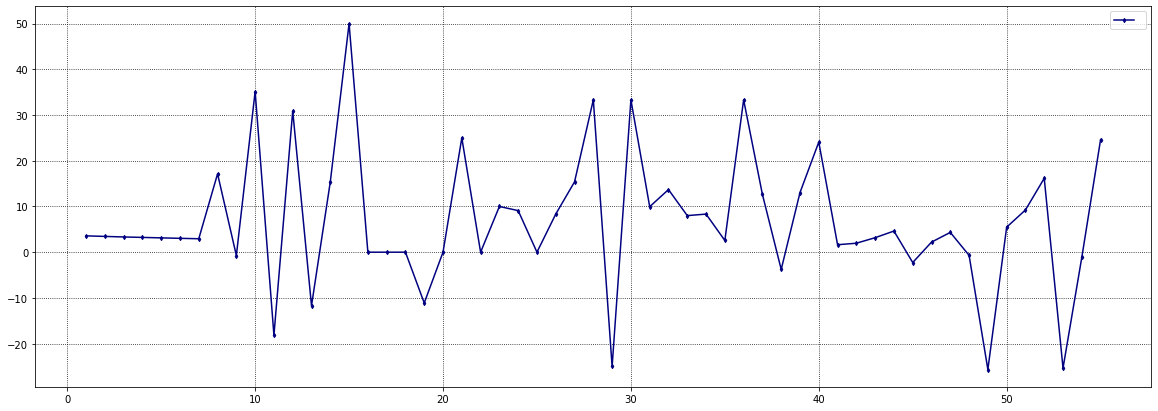

In [15]:
plotSeries(growth.Growth)